# Dependencies

In [5]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
ranepa_colors = [(146/250,26/250,29/250)
,(230/250 , 43/250, 37/250)
,(231/250, 142/250, 36/250)
,(249/250, 155/250, 28/250)
, (242/250, 103/250, 36/250)]

# OLG model

In [6]:
# %load_ext autoreload
# %autoreload 2
from olg import *

- Exogenous labor

Params: $\phi$

$$labor[t] = \phi_s$$

- Endogenous labor

Params:  $\iota$, $\upsilon$

$$ labor[t] = \left[\frac{LaborIncome[t]} {consumption[t] * \iota * (1+\tau_{VA}[t])*price[t]}\right]^{1/\upsilon}$$

In [7]:
steady_guess = np.array([2.65280161e+00, 7.20838767e-01, 1.02735785e+00, 3.30768049e+01,
       1.00000000e+00, 1.00000000e+00, 4.67438156e-01, 3.66973833e+05,
       1.64488185e+04, 2.78606328e+05])

In [8]:
import jax.numpy as jnp
t_0=1
t_1 = 30

In [9]:
olg = OLG_model(T = 300,eta=0.5,utility = "exogenous_labor",steady_guess = steady_guess)

In [10]:
olg.update_a_initial()
olg.create_guess(t_0=t_0, steady_start=t_1)

In [11]:
class JAX_OLG():
    def copy_from(self, model):
        self.price_M = jnp.array(model.price_M).copy()
        self.A = jnp.array(model.A).copy()
        self.Labor = jnp.array(model.Labor).copy()
        self.r = jnp.array(model.r).copy()
        self.tau_pi = jnp.array(model.tau_pi).copy()
        self.Gov = jnp.array(model.Gov).copy()
        self.Consumption = jnp.array(model.Consumption).copy()
        self.psi_O =jnp.array(model.psi_O).copy()
        self.Y_O = jnp.array(model.Y_O).copy()

In [12]:
# static
static = JAX_OLG()
static.copy_from(olg)

In [13]:
def equilibrium(z,  t_0=1,t_1 = t_1, self=olg):
    period = t_1 - t_0

    # border conditions ( from t = t_0 to 

    k = jnp.array(self.k).copy()
    k = k.at[:, (t_0+1):(t_1+1)].set(z[:(period*2)].reshape(2, -1))

    i = jnp.array(self.i).copy()
    i = i.at[:, t_0:t_1].set(z[(period*2):(period*4)].reshape(2, -1))

    l_demand = jnp.array(self.l_demand).copy()
    l_demand = l_demand.at[0, t_0:t_1].set(z[(period*4):(period*5)])
    l_demand = l_demand.at[1, t_0:t_1].set(1 - z[(period*4):(period*5)])

    lmbda_to_price = jnp.array(self.lmbda_to_price).copy()
    lmbda_to_price = lmbda_to_price.at[:, t_0:t_1].set(z[(period*5):(period*7)].reshape(2, -1))

    w = jnp.array(self.w).copy()
    w = w.at[t_0:t_1].set(z[(period*7):(period*8)])

    price = jnp.array(self.price).copy()
    price = price.at[t_0:t_1].set(z[(period*8):(period*9)])

    price_S = jnp.array([self.price_N.copy(), self.price_E.copy()])
    price_S = price_S.at[0, t_0:t_1].set(z[(period*9):(period*10)])
    

    
    
    


    def labor_equation(t, S, self=self):
        return (1-self.alpha)*price_S[S, t]  * (k[S, t]/l_demand[S, t] * static.A[0,t]/static.A[S, t])**self.alpha - w[t]/static.A[0, t]

    def investment_equation(t, S, self=self):
        return  1 -\
                lmbda_to_price[S, t] * (
                                    1 - self.psi/2 *(
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                                    - 1
                                                    )**2\
                                      - self.psi * (
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                                    ) * \
                                                   (
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1]) - 1
                                                   ) 
                                    )-\
               lmbda_to_price[S,t+1]*price[t+1]/price[t]*self.psi/(1+static.r[t+1]) *\
               (
                    i[S,t+1]/i[S,t]*(k[S, t+1]*static.A[0, t+1]*static.Labor[t+1])/\
                                    (k[S,t] * static.Labor[t] * static.A[0, t])
               )**2 *\
               (
                    i[S,t+1]/i[S,t]*(k[S, t+1]*static.A[0, t+1]*static.Labor[t+1])/\
                                    (k[S,t] * static.Labor[t] * static.A[0, t])
                    - 1
               )

    def capital_equation(t, S, self=self):
        return 1/(1+static.r[t+1]) * (
                                      (1-static.tau_pi[t+1]) * self.alpha * price_S[S, t+1] *\
                                      (k[S, t]/l_demand[S, t] * static.A[0,t]/static.A[S, t])**(self.alpha-1) +\
                                      static.tau_pi[t+1] * self.delta * price[t+1] +\
                                      lmbda_to_price[S, t+1]*price[t+1] * (1-self.delta) 
                                    ) -\
                lmbda_to_price[S, t] * price[t]
    def capital_accomodation_equation(t, S, self=self):
        return (1-self.delta)+\
                i[S,t] * (1-self.psi / 2 *(i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                             (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                           - 1
                                          )**2 
                         ) -\
                k[S,t+1]*static.A[0, t+1]*static.Labor[t+1]/(k[S,t] * static.Labor[t] * static.A[0, t])


    
    def final_good_market_equation(t, self=self):
        return price[t] - (static.price_M[t])**self.omega * (price_S[0, t])**(1-self.omega)

    def intermediate_good_market_equation(t, self=self):
        return price_S[0,t]*(
                                (k[0,t]/l_demand[0,t])**self.alpha *l_demand[0,t] - \
                                static.Gov[t]/(static.A[0,t]*static.Labor[t])
                            ) - \
                (1-self.omega) * price[t] * \
                (
                    (static.Consumption[t] + static.psi_O[t] * static.Y_O[t])/(static.A[0,t]*static.Labor[t]) +\
                    i[0,t]*k[0,t] + i[1,t]*k[1,t]
                )

    
    def system(t):
        return  ( 
                labor_equation(t,  0)**2+
                labor_equation(t,  1)**2+
                investment_equation(t,  0)**2+
                investment_equation(t,  1)**2+
                capital_equation(t,  0)**2 +
                capital_equation(t,  1)**2 +
                capital_accomodation_equation(t,  0)**2+
                capital_accomodation_equation(t,  1)**2+
                final_good_market_equation( t)**2+
                intermediate_good_market_equation( t)**2
        )
    
    
    return jnp.apply_along_axis(system, 0, jnp.arange(t_0, t_1)).sum()

In [14]:
def update_guess(self, t_0, t_1):
    z = np.concatenate([self.k[:, (t_0+1):(t_1+1)].ravel(),
                  self.i[:, t_0:t_1].ravel(),
                  self.l_demand[0, t_0:t_1].ravel(),
                  self.lmbda_to_price[:, t_0:t_1].ravel(),
                  self.w[t_0:t_1],
                  self.price[t_0:t_1],
                  self.price_N[t_0:t_1]
                 ])
    return z

In [15]:
def update_optimal_trajectory(self, z, t_0, t_1):
    self.k[0, (t_0+1):(t_1+1)],\
    self.k[1, (t_0+1):(t_1+1)],\
    self.i[0, t_0:t_1],\
    self.i[1, t_0:t_1],\
    self.l_demand[0, t_0:t_1],\
    self.lmbda_to_price[0, t_0:t_1],\
    self.lmbda_to_price[1, t_0:t_1],\
    self.w[t_0:t_1],\
    self.price[t_0:t_1],\
    self.price_N[t_0:t_1] = np.split(z, 10)
    return self

In [16]:
z_guess = update_guess(olg, t_0, t_1)

In [17]:
print(z_guess.shape)

(290,)

In [18]:
# %timeit equilibrium(z_guess)

In [19]:
import cyipopt
import sparsejac
import jax

In [20]:
get_diagonal = lambda k: jax.numpy.eye(N = int(t_1-t_0), k=k, dtype=int)
hessian_diagonal = get_diagonal(-1)+get_diagonal(0)+get_diagonal(1)
hessian_structure = jnp.nonzero(jnp.tile(hessian_diagonal, reps = (int(len(z_guess)/(t_1-t_0)),int(len(z_guess)/(t_1-t_0)))))

In [21]:
# obj_jit = jit(equilibrium)
# obj_grad = jit(jacfwd(obj_jit))
# obj_hess = jit(jacrev(jacfwd(obj_jit)))

In [31]:
obj_jit = equilibrium
obj_grad = jacfwd(obj_jit)
obj_hess = jacrev(jacfwd(obj_jit))

In [32]:
class OLG_problem():

    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return obj_jit(x)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        return obj_grad(x)

#     def constraints(self, x):
#         """Returns the constraints."""
#         return np.array((np.prod(x), np.dot(x, x)))

#     def jacobian(self, x):
#         """Returns the Jacobian of the constraints with respect to x."""
#         return np.concatenate((np.prod(x)/x, 2*x))

    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        return hessian_structure

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        # row, col = self.hessianstructure()
        
        return obj_hess(x)[row, col]

#     def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
#                      d_norm, regularization_size, alpha_du, alpha_pr,
#                      ls_trials):
#         """Prints information at every Ipopt iteration."""

#         msg = "Objective value at iteration #{:d} is - {:g}"

#         print(msg.format(iter_count, obj_value))

In [33]:
nlp = cyipopt.Problem(
   n=len(z_guess),
   m=0,
   problem_obj=OLG_problem(),
   lb=jnp.repeat(10e-19, len(z_guess)),
   ub=jnp.repeat(10e19, len(z_guess))
)

In [34]:
nlp.add_option('mu_strategy', 'adaptive')
nlp.add_option('tol', 1e-3)
nlp.add_option('max_iter',50)

In [36]:
x.shape

(290,)

In [38]:
info.keys()

dict_keys(['x', 'g', 'obj_val', 'mult_g', 'mult_x_L', 'mult_x_U', 'status', 'status_msg'])

In [35]:
x, info= nlp.solve(z_guess)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    42195

Total number of variables............................:      290
                     variables with only lower bounds:      290
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0732690e+00 0.00e+00 4.11e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00  

In [ ]:
149.453 seconds for 100 iterations ~ fun = 2.3

In [ ]:
# tol = 1e-3
# result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
#                     , options = {"max_iter":10,
#                                  b"print_level":5,
#                                  "check_derivatives_for_naninf":"no"}
#                     , tol=tol)

In [1]:
aggregate = Aggregate_plot(olg, t_0 = 0, t_1 = 100, name = 'test');
aggregate.create(alpha=.5, linestyle='dashed');


NameError: name 'Aggregate_plot' is not defined

In [45]:
olg = update_optimal_trajectory(olg, result['x'], t_0=1, t_1=t_1)

In [46]:
aggregate.update(alpha = 1.)

In [48]:
send_figure(aggregate.fig)

In [49]:
aggregate.fig.savefig('aggregates_1it.jpg')

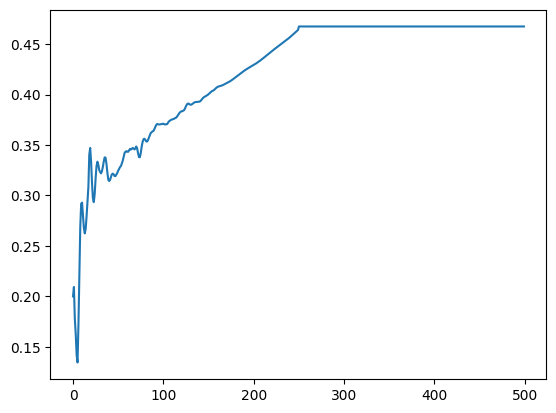

In [149]:
plt.plot(olg.tau_VA)

In [147]:
for t in range(1, 250):
    olg.update_government(t)

In [149]:

capit_new = capit.copy()

In [150]:
capit_new[2:6] = result['info']['x'][:4]

array([3.07928781, 3.01301586, 2.93367805, 2.86279235])

In [117]:
[6, 25, 211]

[6, 25, 211]

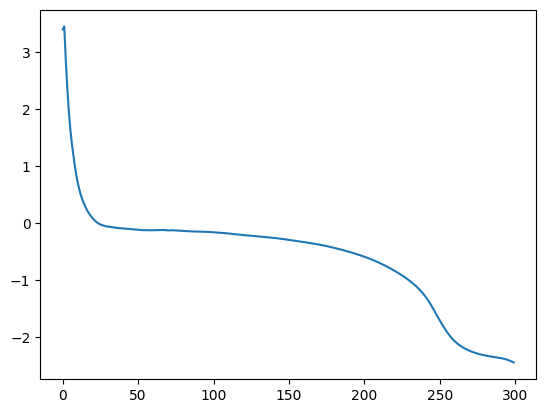

In [844]:
plt.plot(olg.k[0,:300])

In [804]:
olg.guess = {}

In [805]:
for t in range(30,40):
    olg.evaluate_guess(t)

In [806]:
olg.update_guess(30,40)

In [809]:
[item[1] for _, item in olg.guess.items()]

[1.1009113394288763,
 1.0912111314268196,
 1.1027023710651664,
 1.1352602852409481,
 1.1708411595383388,
 1.194694285766265,
 1.2041864058869298,
 1.2019868803115736,
 1.2284092178039432,
 1.2284287597238195]

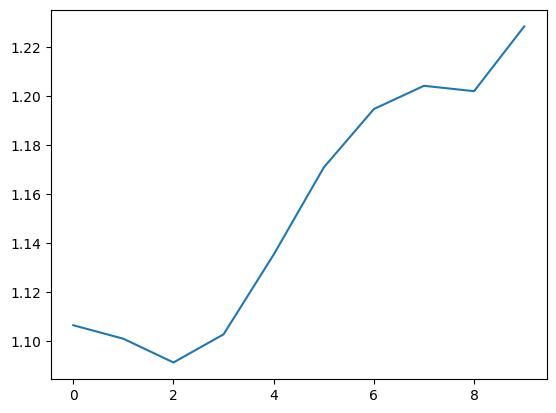

In [811]:
plt.plot(olg.k[0,30:40])

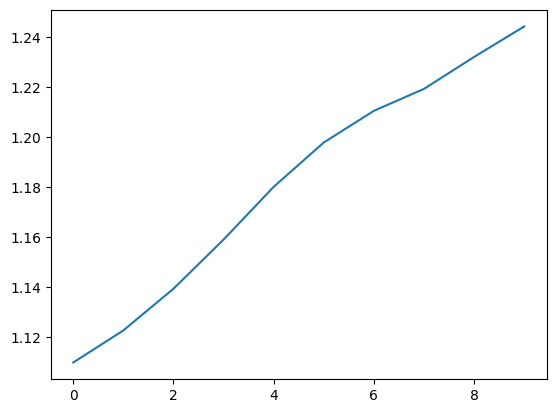

In [815]:
plt.plot(olg.price[30:40])

In [817]:
k_star = [olg.history[i][-1]['info']['x'][1] for i in range(1,250)]
k_E_star = [olg.history[i][-1]['info']['x'][5] for i in range(1,250)]

In [825]:
price_star = [olg.history[i][-1]['info']['x'][-1] for i in range(1,250)]


In [685]:
def capital_gain(self, t):
    if t == 0:
        lag_i = self.initial["I_N"]/self.initial["K_N"], self.initial["I_E"]/self.initial["K_E"]
        lag_K = self.initial["K_N"], self.initial["K_E"]
    else:
        lag_i = self.i[:,t-1]
        lag_K = self.K[:, t-1]
    i_N = self.i[0,t]
    k_N = self.k[0,t]

    return ( (1-self.delta)+\
                       i_N * (1-self.psi / 2 *(i_N/lag_i[0]*self.K[0,t]/lag_K[0] - 1)**2 ) -\
            k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t])

In [686]:
cap_gain = [capital_gain(olg, t)**2 for t in range(250)]

In [820]:
t = 300

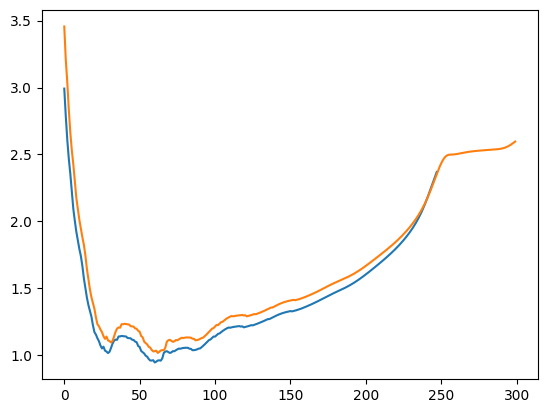

In [821]:
plt.plot(k_star[1:(t+1)])
plt.plot(olg.k[0,1:(t+1)])

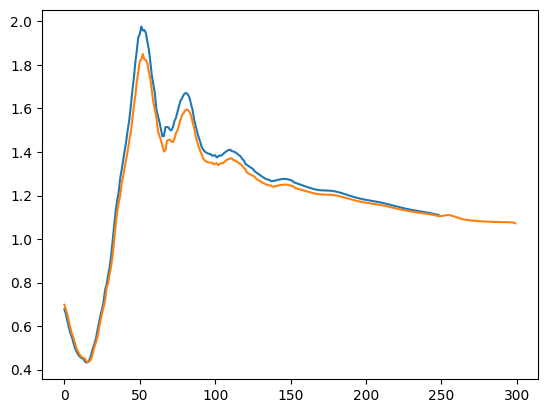

In [822]:
plt.plot(k_E_star[:(t)])
plt.plot(olg.k[1,1:(t+1)])

In [824]:
olg.guess

{1: array([0.05989419, 3.20818488, 0.82147788, 0.85260292, 0.09329713,
        0.67566022, 0.97023122, 1.06891879, 0.98219326, 0.97509678]),
 2: array([0.05156243, 3.03918777, 0.79699564, 0.88345139, 0.08451581,
        0.65294971, 1.0256353 , 1.02909073, 0.94976171, 0.93007496]),
 3: array([0.04116723, 2.83717455, 0.80284159, 0.88314788, 0.07791382,
        0.61993345, 1.02564834, 1.04702287, 0.96141515, 0.94616361]),
 4: array([0.03351059, 2.66522209, 0.8174668 , 0.8652546 , 0.07293765,
        0.59002334, 1.00530369, 1.07682023, 0.98714306, 0.98197863]),
 5: array([0.02857237, 2.5314239 , 0.82525596, 0.85323256, 0.07073268,
        0.56591339, 0.99815058, 1.09572169, 1.00223228, 1.00317051]),
 6: array([0.02529085, 2.42637615, 0.82472943, 0.85635636, 0.07136854,
        0.54678092, 1.01084176, 1.10005598, 1.00250548, 1.00357223]),
 7: array([0.02281335, 2.29964995, 0.82337858, 0.86496015, 0.07400225,
        0.52212031, 1.0275109 , 1.10551489, 1.00092494, 1.00136757]),
 8: array([0.

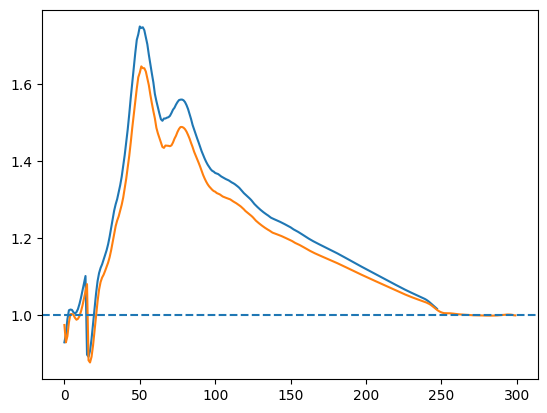

In [826]:
plt.plot(price_star[1:(t+1)])
plt.plot(olg.price[1:(t+1)])
plt.axhline(1, linestyle='dashed')

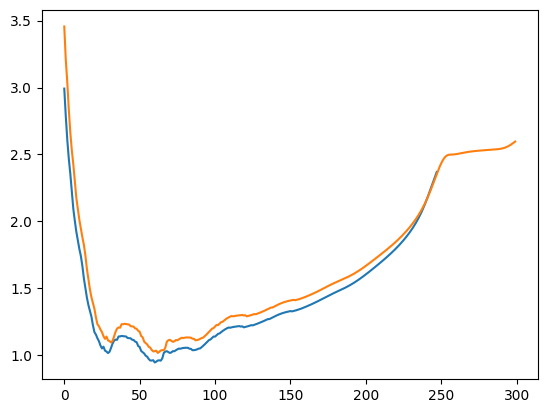

In [830]:
plt.plot(k_star[1:(t+1)])
plt.plot(olg.k[0,1:(t+1)])

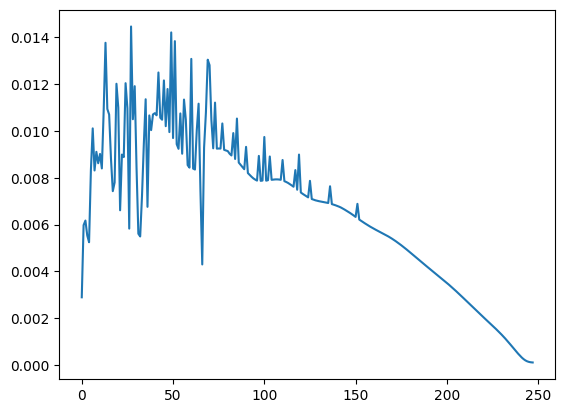

In [837]:
# plt.plot(k_star[1:(t+1)])
# plt.plot(olg.k[0,1:(t+1)])
plt.plot(cap_gain[2:(t+2)])
# plt.plot((olg.K[0,1:(t+1)]*(1-olg.delta) + olg.I[0,1:(t+1)] * (1- olg.psi / 2 *  (olg.I[0,1:(t+1)]/olg.I[0, :t] - 1)**2 ))/olg.A[0, 1:(t+1)]/olg.Labor[2:(t+2)])
# plt.plot(cap_gain[:20])

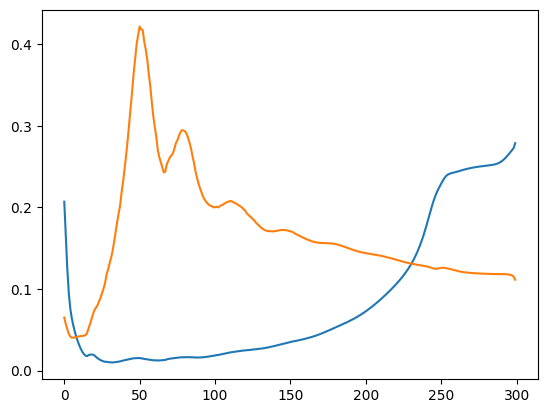

In [832]:
plt.plot(olg.I[0,1:(t+1)]/olg.A[0, 1:(t+1)]/olg.Labor[1:(t+1)])
plt.plot(olg.I[1,1:(t+1)]/olg.A[0, 1:(t+1)]/olg.Labor[1:(t+1)])

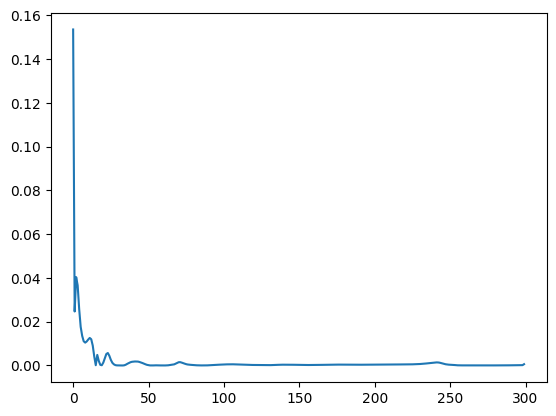

In [833]:
plt.plot(olg.psi / 2 *  (olg.I[0,1:(t+1)]/olg.I[0, :t] - 1)**2 )

In [834]:
cap_gain[15]

0.013770870545512131

In [835]:
cap_gain[15]

0.013770870545512131

In [598]:
k_diff = np.sum([np.diff([step['info']['x'][1] for step in item])**2 for t, item in olg.history.items() if len(item)>0 and t<250], axis=0)
# i_diff = np.sum([np.diff([step['info']['x'][0] for step in item])**2 for t, item in olg.history.items() if len(item)>0], axis=0)
# ke_diff = np.sum([np.diff([step['info']['x'][5] for step in item])**2 for t, item in olg.history.items() if len(item)>0], axis=0)

In [599]:
all_diff = np.sum([np.diff([step['info']['x'][i] for step in item])**2 for t, item in olg.history.items() if len(item)>0 for i in range(olg.history[1][0]['info']['x'].shape[0])], axis=0)

/home/mkhlgrv/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: operands could not be broadcast together with shapes (101,) (34,) 

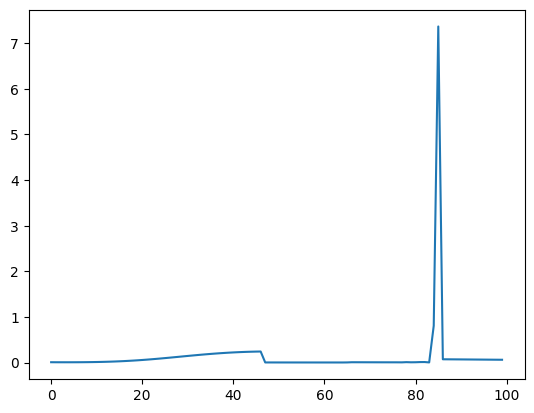

In [600]:
plt.plot(k_diff[1:])

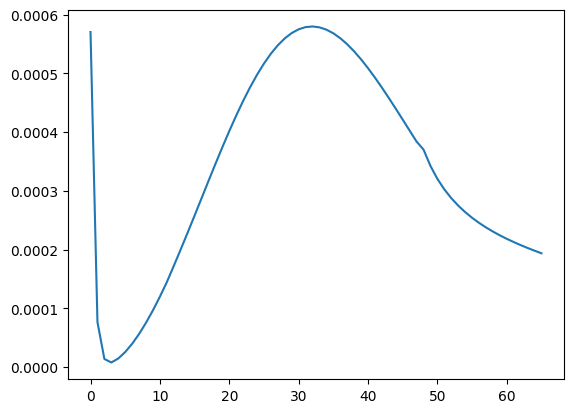

In [601]:
plt.plot(i_diff)

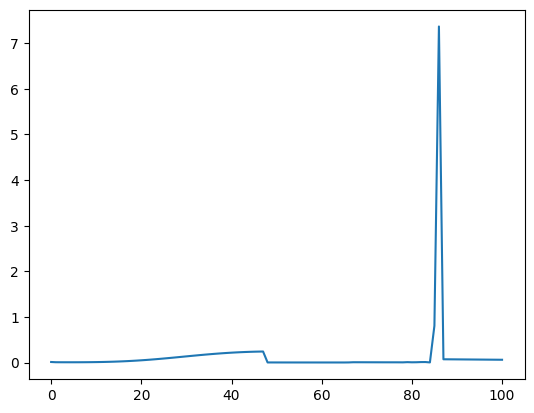

In [602]:
plt.plot(k_diff)

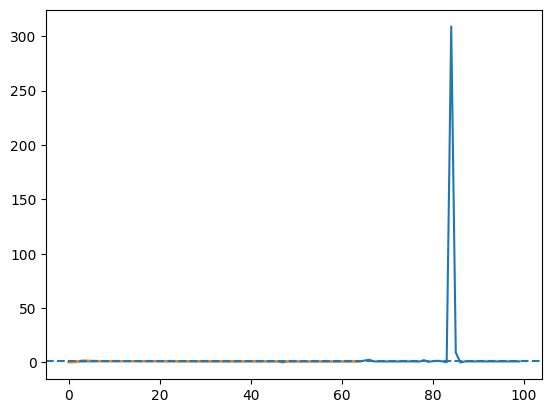

In [603]:
plt.plot(k_diff[1:]/k_diff[:-1])
plt.plot(i_diff[1:]/i_diff[:-1])
plt.axhline(1, linestyle='dashed')
# plt.plot(ke_diff[15:30]/ke_diff[14:29])

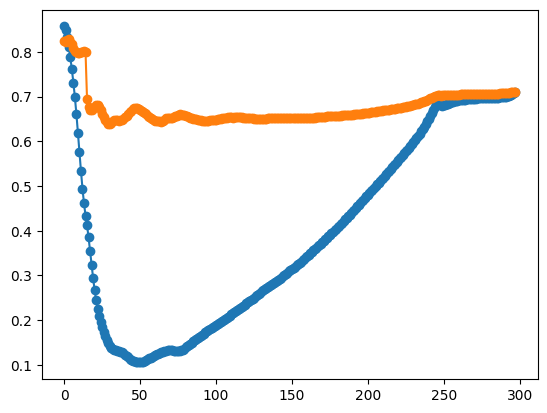

In [604]:
t = range(2,300)
plt.plot(olg.I[0,t]/(olg.I[:,t].sum(axis=0)), marker = 'o')
# plt.plot(olg.K[0,t]/(olg.K[:,t].sum(axis=0)), marker = 'o')
plt.plot(olg.l_demand[0,t], marker = 'o')

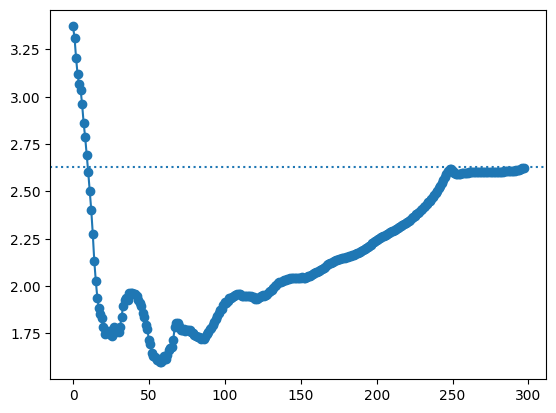

In [605]:
plt.plot(olg.k[0,t], marker = 'o')
plt.axhline(olg.steady_state[0], linestyle = 'dotted')

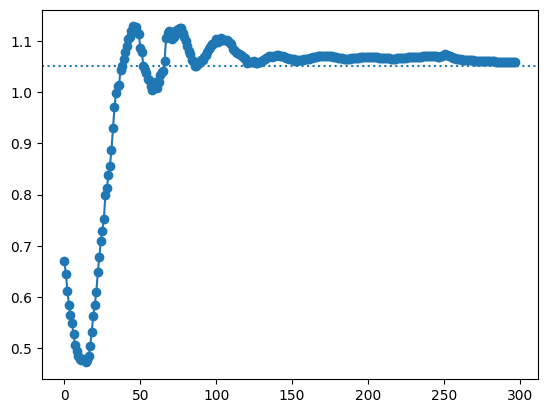

In [606]:
plt.plot(olg.k[1,t], marker = 'o')
plt.axhline(olg.steady_state[2], linestyle = 'dotted')

In [525]:
olg.steady_state

array([2.62878054e+00, 7.14311583e-01, 1.05137893e+00, 3.30768049e+01,
       1.00000000e+00, 1.00000000e+00, 4.63579064e-01, 3.68636002e+05,
       1.66799024e+04, 5.24248595e+05])

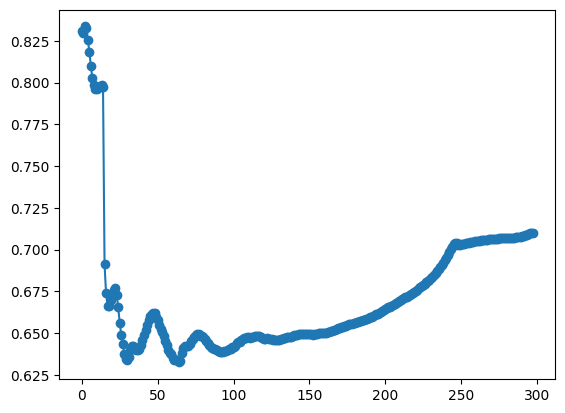

In [526]:
# plt.plot(olg.k[0,t]/(olg.k[:,t].sum(axis=0)), marker = 'o')
plt.plot(olg.l_demand[0,t], marker = 'o')

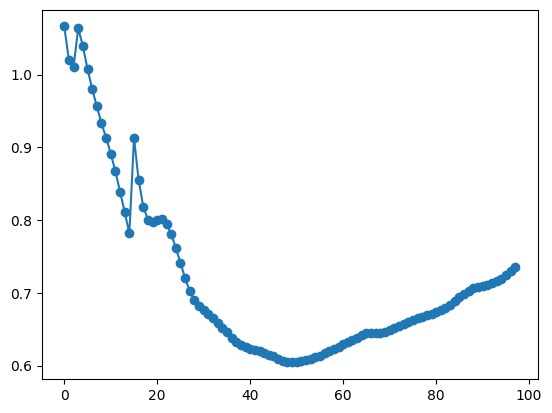

In [560]:
plt.plot(olg.Consumption[2:t]/(olg.N[:,:,2:t].sum(axis=(0,1))*olg.A[0,2:t]), marker = 'o')
# plt.plot(olg.Assets[2:200]/(olg.N[:,:,2:200].sum(axis=(0,1))*olg.A[0,2:200]))

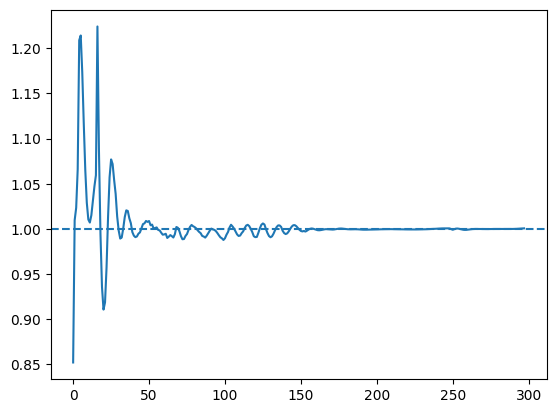

In [535]:
plt.plot(olg.tau_VA[2:300]/olg.tau_VA[1:299])
plt.axhline(1, linestyle='dashed')

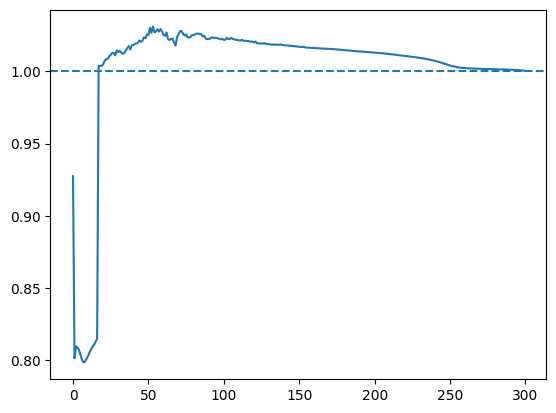

In [836]:
# plt.plot(olg.l_demand[1,:300])
plt.plot(((1-olg.omega)*(olg.I[0,:300]+olg.I[1,:300]+olg.Consumption[:300]+olg.Y_O[:300]*olg.psi_O[:300])+olg.price_N[:300]/olg.price[:300]*olg.Gov[:300]+olg.Y[1, :300])/olg.GDP[:300])
plt.axhline(1, linestyle='dashed')

In [ ]:
for i in range(5):
    olg_exogenous_labor.update_steady_state()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



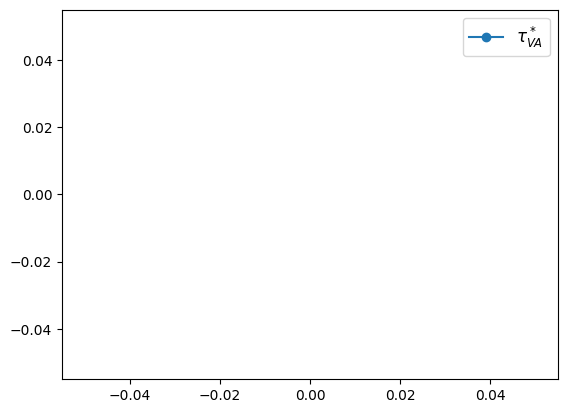

In [80]:
plt.plot([i[0]['info']['x'][6] for i in olg_exogenous_labor.steady_state_path], label = r'$\tau_{VA}^*$',marker='o')
plt.legend()
plt.show()

In [6]:
olg_exogenous_labor.update_a_initial()
olg_exogenous_labor.create_guess(t_0=1,steady_start=250)

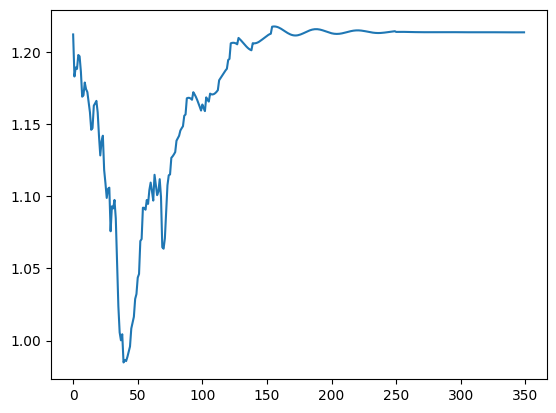

In [108]:
plt.plot(olg.Labor[:350]/olg.N[:,:,:350].sum(axis=(0,1)))

In [7]:
for t in range(1,10):
    olg_exogenous_labor.update_guess(t)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



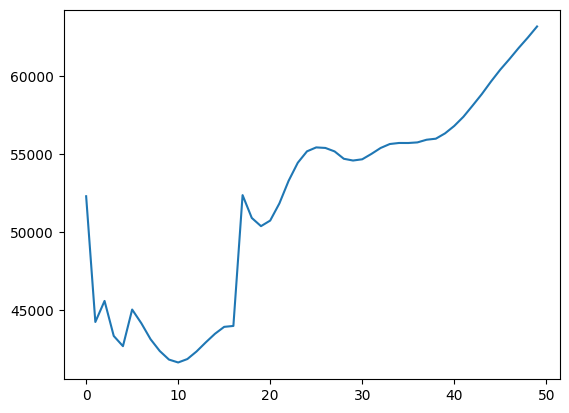

In [109]:
plt.plot(olg.Consumption[:50])

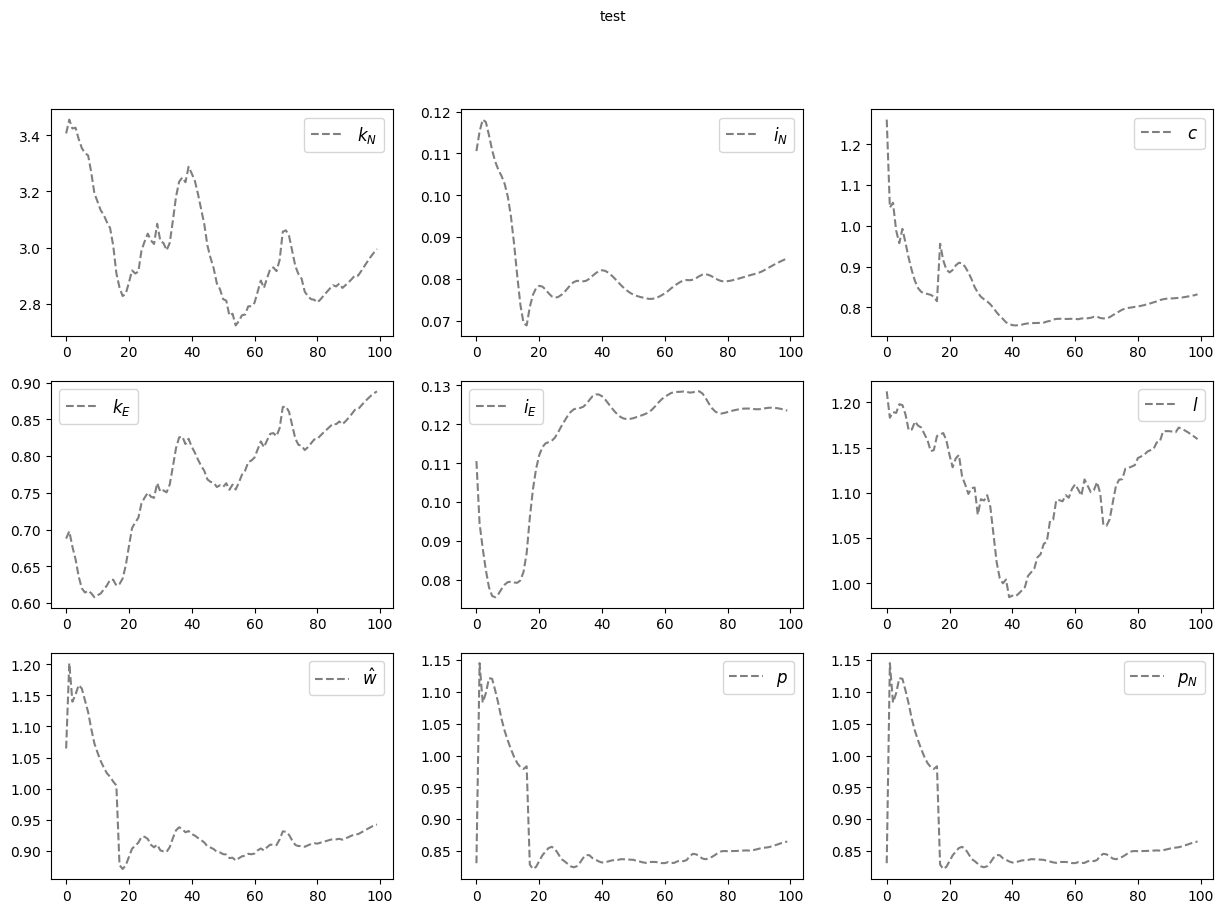

In [110]:
aggregate = Aggregate_plot(olg, t_0 = 0, t_1 = 100, name = 'test')
aggregate.create(alpha=.5, linestyle='dashed');

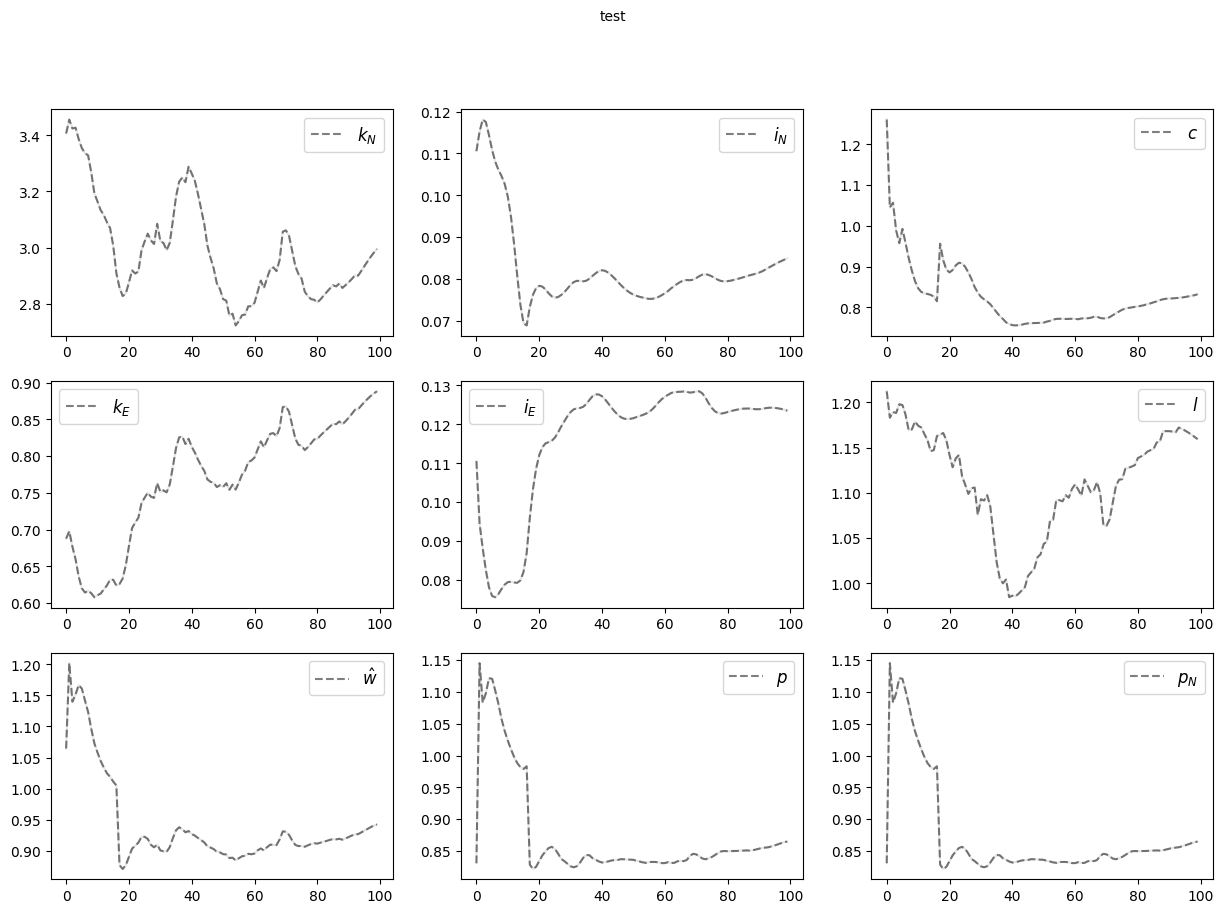

In [111]:
aggregate.update(alpha=.1, linestyle='solid')  
aggregate.fig

In [88]:
government = Gov_plot(olg, t_0 = 0, t_1 = 100, name = 'test')
government.create(alpha=.5, linestyle='dashed')

TypeError: super(type, obj): obj must be an instance or subtype of type

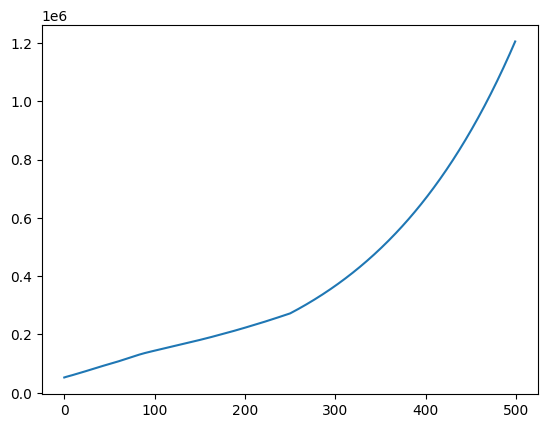

In [89]:
plt.plot(olg_exogenous_labor.Consumption)

In [90]:
err = Error_plot(olg_exogenous_labor, t_0 = 2, t_1 = 300, name = 'test')
err.create(alpha=.5, linestyle='dashed');

TypeError: super(type, obj): obj must be an instance or subtype of type

In [91]:
err.update(alpha=.1, linestyle='solid')  
err.fig

NameError: name 'err' is not defined

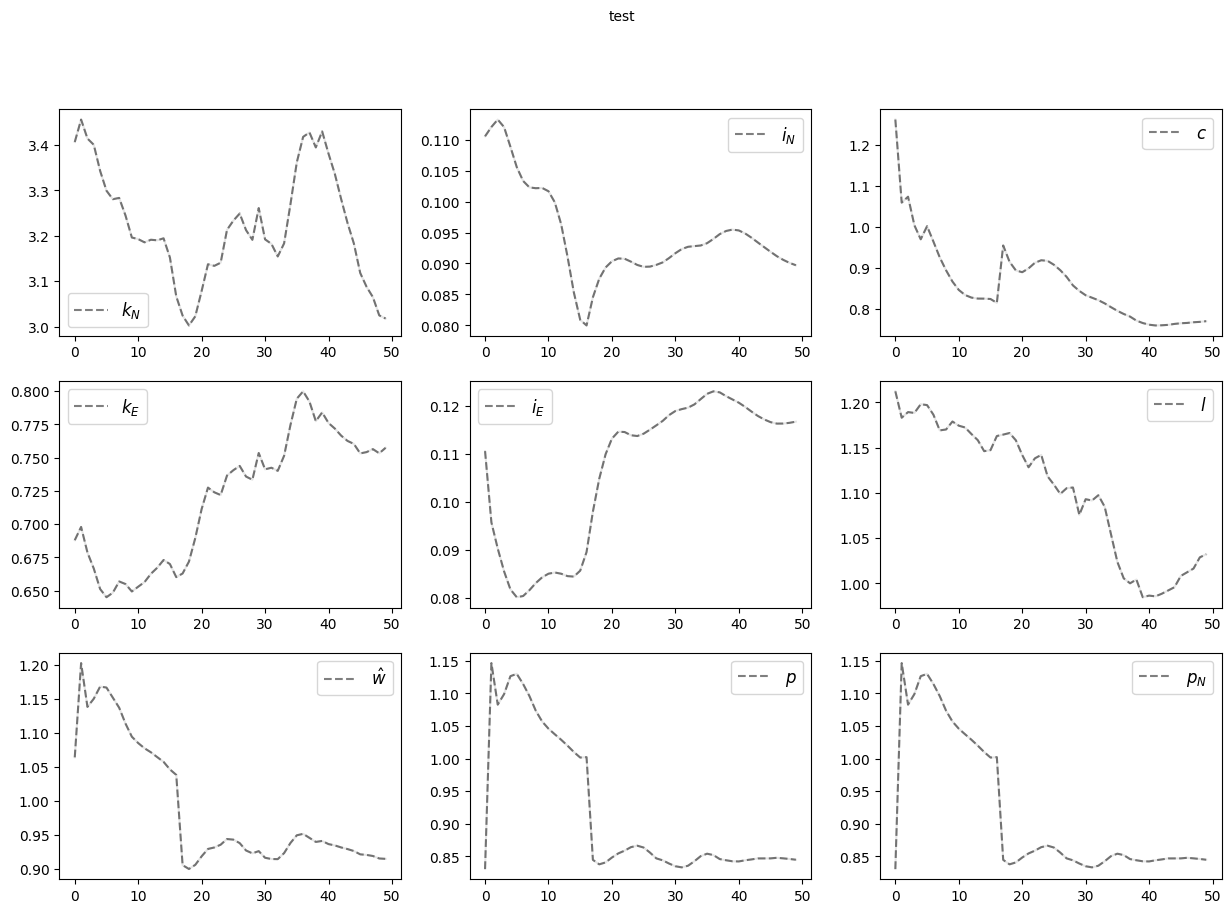

In [92]:
aggregate.update(alpha=.1, linestyle='solid')  
aggregate.fig


KeyboardInterrupt



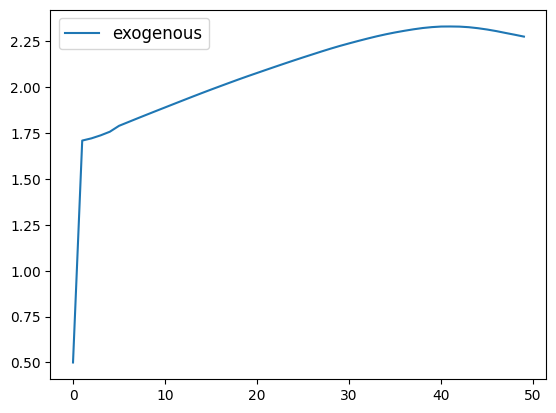

In [93]:
t = 50
plt.plot(range(t), olg_exogenous_labor.c[1, 79,:t], label = "exogenous")
plt.legend()
plt.show()

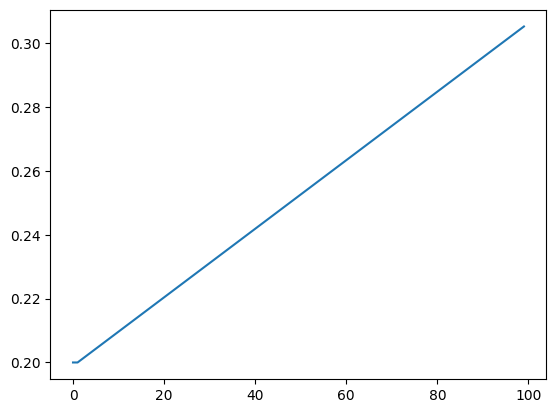

In [94]:
plt.plot(olg_exogenous_labor.tau_VA[:100])

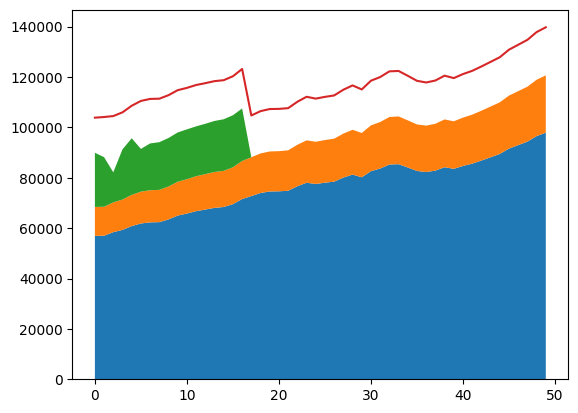

In [95]:
# plt.plot((olg_exogenous_labor.I.sum(axis=0)/olg_exogenous_labor.GDP)[:50], label = 'I')
Y = [(olg_exogenous_labor.Y[0]*olg_exogenous_labor.price)[:50],
     (olg_exogenous_labor.Y[1]*olg_exogenous_labor.price)[:50],
    (olg_exogenous_labor.Y_O*olg_exogenous_labor.price_O)[:50]]
plt.stackplot(range(50), *Y, baseline='zero')

plt.plot(olg_exogenous_labor.GDP[:50])

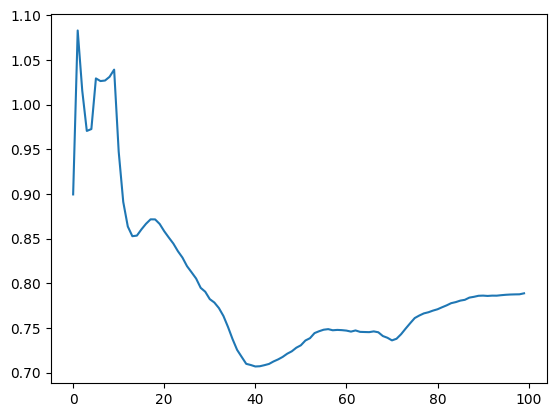

In [352]:
plt.plot(olg_exogenous_labor.Consumption[:100]/olg_exogenous_labor.N.sum(axis=(0,1))[:100]/olg_exogenous_labor.A[0,:100])

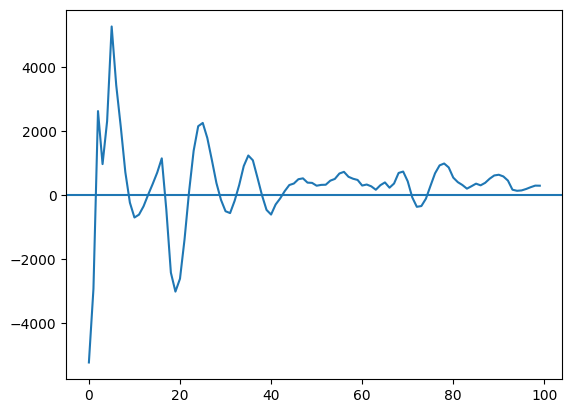

In [105]:
plt.plot(olg.Deficit[:100])
plt.axhline(0)

In [107]:
t=300

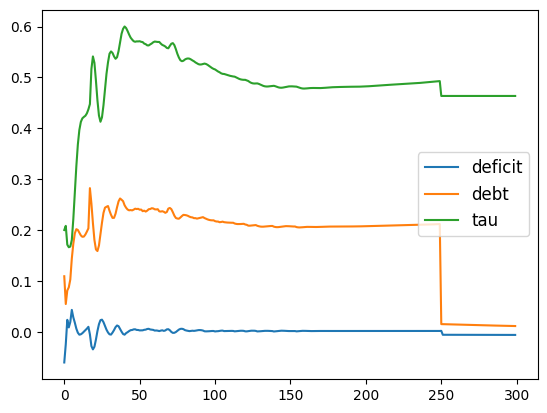

In [109]:
plt.plot(olg.Deficit_to_GDP[:t], label = 'deficit')
plt.plot(olg.Debt_to_GDP[:t], label = 'debt')
plt.plot(olg.tau_VA[:t], label = 'tau')
plt.legend()

In [336]:
olg_exogenous_labor.Deficit_to_GDP[0]

-0.02938555589489116

In [337]:
olg_exogenous_labor.initial['Debt']

9410

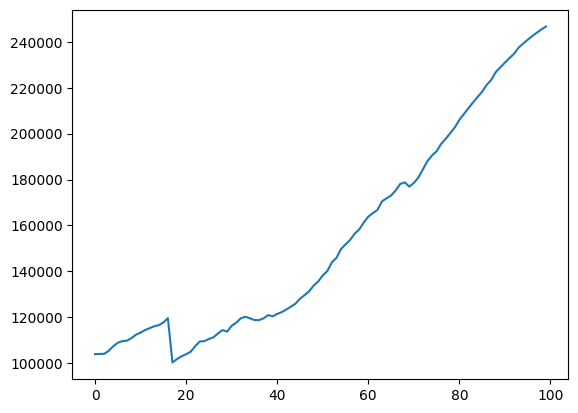

In [110]:
plt.plot(olg.GDP[:100])

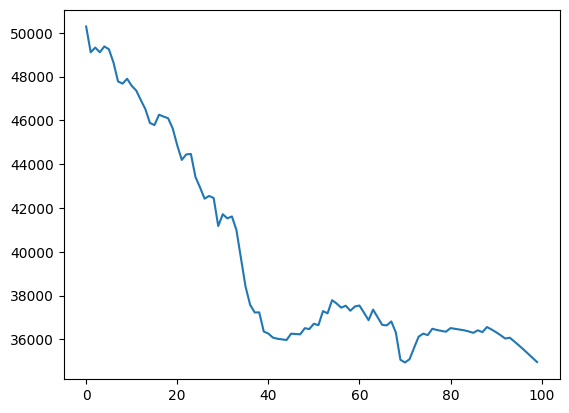

In [111]:
plt.plot(olg.L[0,:100]+olg.L[1,:100])

 $$u(c_{s,g,t}, l_{s,g, t})=
     \log c_{s,g,t} -  \frac{\iota}{1+\upsilon} {l_{s,g,t}}^{1+\upsilon}, $$

$$ \iota  = \frac{LaborIncome[t]} {consumption[t]  * labor^\upsilon * (1+\tau_{VA}[t])*price[t]}$$

In [60]:
endogenous_iota = np.array([np.nanmean(labor_income_vector(olg_exogenous_labor, s, default.G_MODEL-1, 0, default.G_MODEL)/\
    (olg_exogenous_labor.c[s,default.G_MODEL-1, :default.G_MODEL]*\
     olg_exogenous_labor.l[s,default.G_MODEL-1, :default.G_MODEL]**(olg_exogenous_labor.upsilon) *\
     (1+olg_exogenous_labor.tau_VA[:default.G_MODEL])*olg_exogenous_labor.price[:default.G_MODEL])) for s in range(2)])
print(endogenous_iota)

[1.18147635 0.25842031]


/tmp/ipykernel_255067/421840932.py:1: RuntimeWarning: invalid value encountered in divide
  endogenous_iota = np.array([np.nanmean(labor_income_vector(olg_exogenous_labor, s, default.G_MODEL-1, 0, default.G_MODEL)/\


In [61]:
olg_endogenous_labor = OLG_model(
                   upsilon = 5.,
                    eta = 0.1
                 , iota = endogenous_iota
                 , utility = "hybrid",
steady_guess=steady_guess)

In [6]:
for i in range(10):
    olg_endogenous_labor.update_steady_state()

NameError: name 'olg_endogenous_labor' is not defined

In [29]:
plt.plot([i[0]['info']['x'][6] for i in olg_endogenous_labor.steady_state_path], label = '$l_0^*$',marker='o')
plt.legend()
plt.show()

NameError: name 'olg_endogenous_labor' is not defined

In [67]:
olg_endogenous_labor.update_a_initial()
olg_endogenous_labor.create_guess(t_0=0,steady_start = 100)

KeyboardInterrupt: 

In [68]:
olg_endogenous_labor.Rho_deficit_to_GDP

AttributeError: 'OLG_model' object has no attribute 'Rho_deficit_to_GDP'

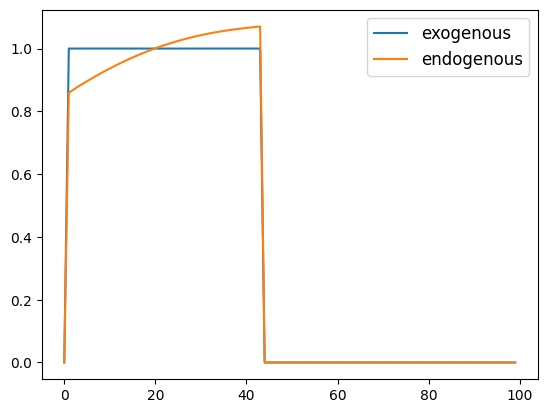

In [71]:
t = 100
plt.plot(range(t), olg_exogenous_labor.l[0,80,:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.l[0,80,:t], label = "endogenous")
plt.legend()
plt.show()

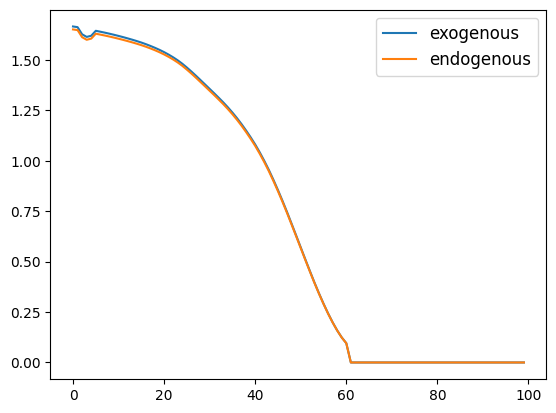

In [80]:
t = 100
plt.plot(range(t), olg_exogenous_labor.c[0,60,:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.c[0,60,:t], label = "endogenous")
plt.legend()
plt.show()

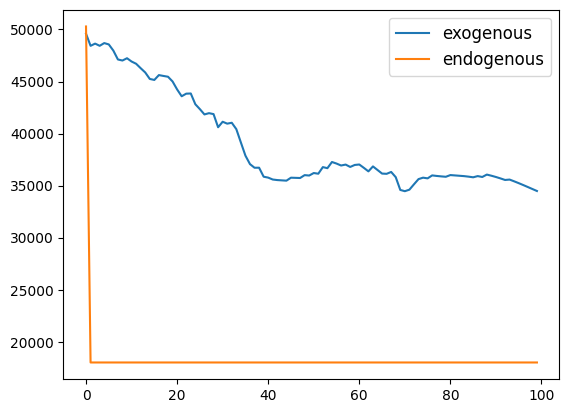

In [81]:
t = 100
plt.plot(range(t), olg_exogenous_labor.Labor[:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.Labor[:t], label = "endogenous")
plt.legend()
plt.show()

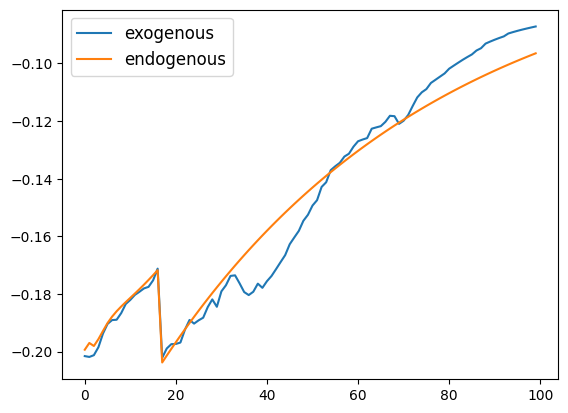

In [84]:
t = 100
plt.plot(range(t), olg_exogenous_labor.Debt_to_GDP[:t], label = "exogenous")
plt.plot(range(t), olg_endogenous_labor.Debt_to_GDP[:t], label = "endogenous")
plt.legend()
plt.show()

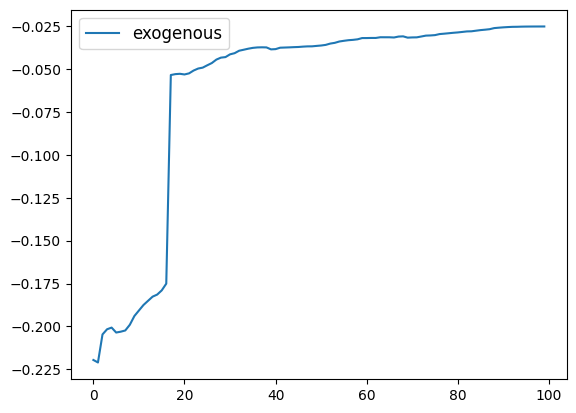

In [96]:
t = 100
plt.plot(range(t), olg_exogenous_labor.Deficit_to_GDP[:t], label = "exogenous")
plt.legend()
plt.show()

- labor m and f
- population UN
- calibration
- scenarios: population, oil, 

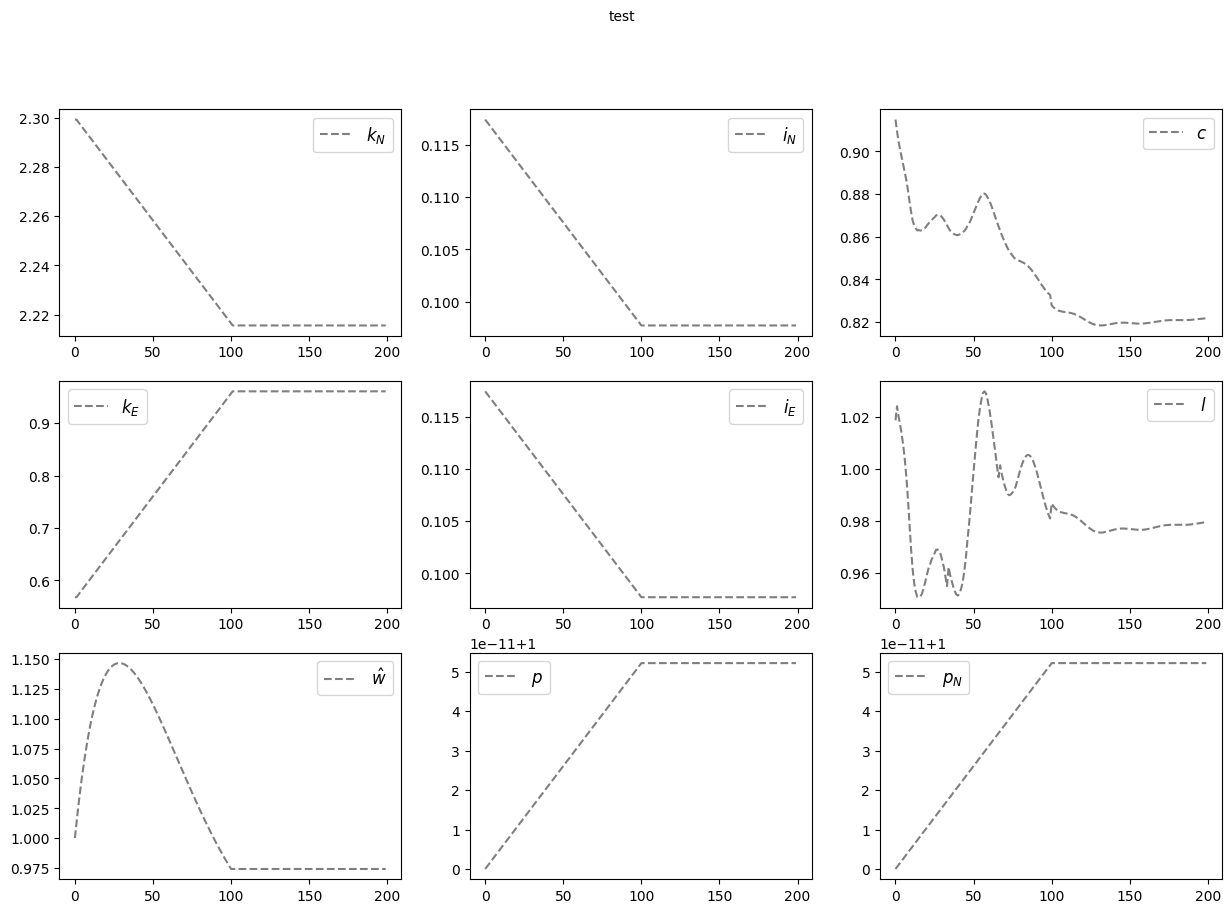

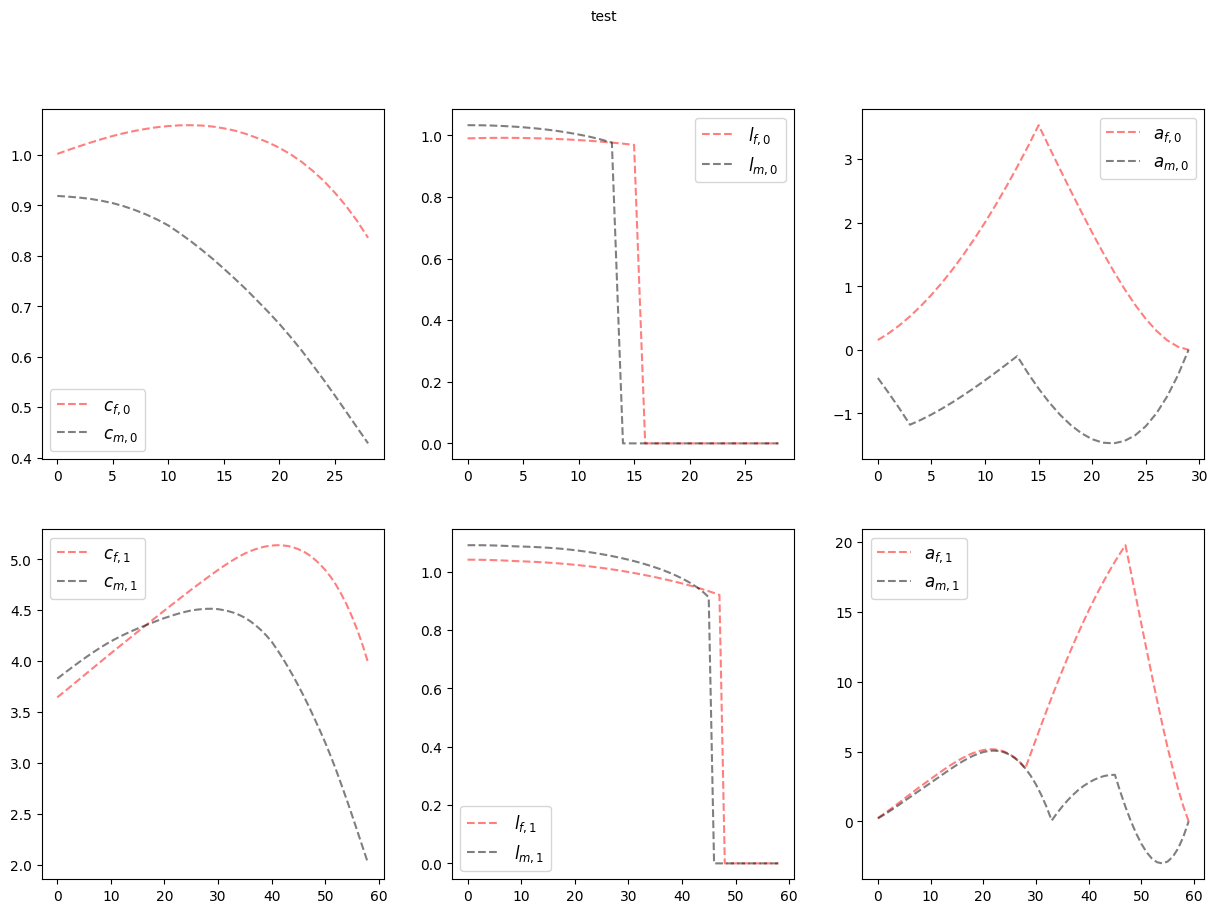

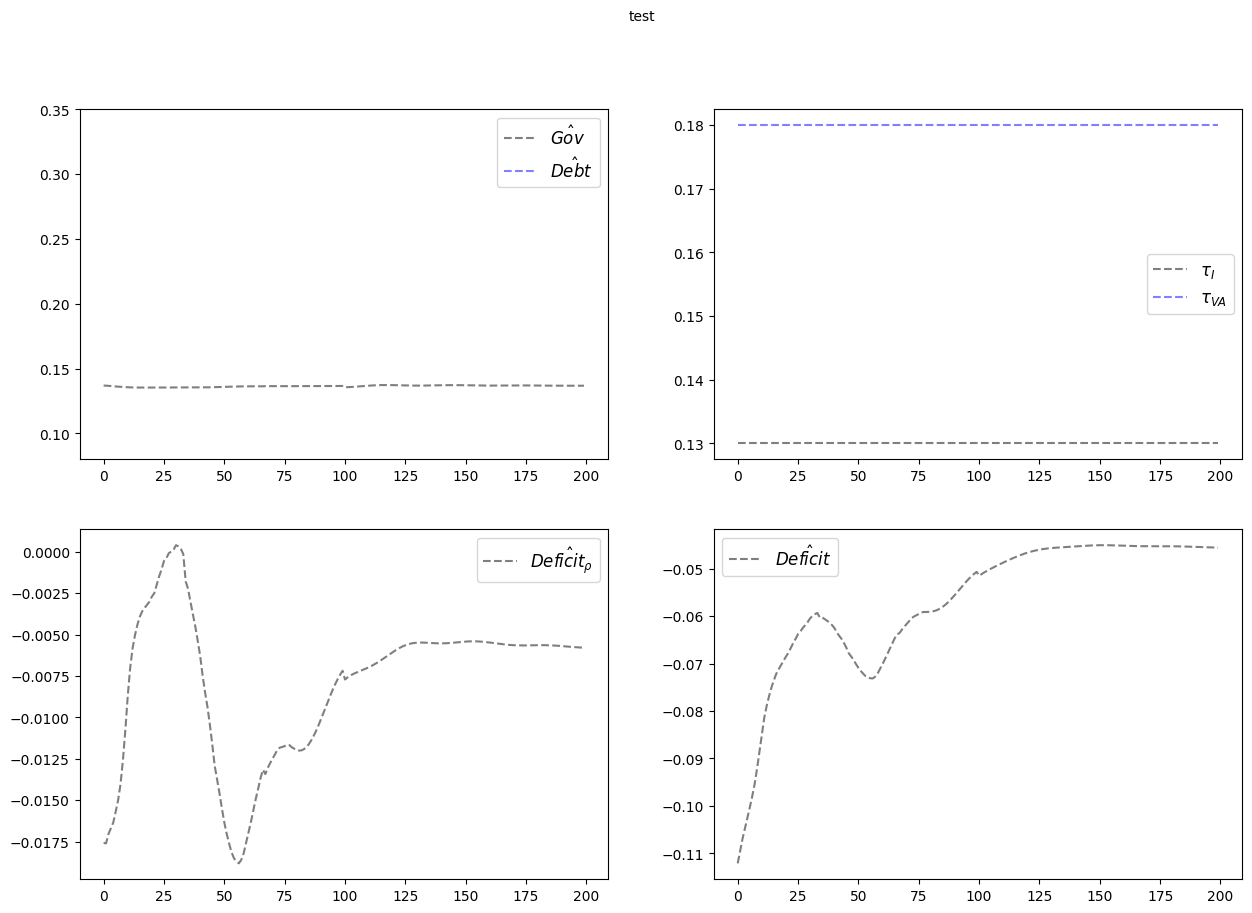

In [19]:
aggregate = Aggregate_plot(olg, t_0 = 0, t_1=olg.T, name = 'test')
household = Household_plot(olg, g_0=30, g_1=150, name = 'test')
government = Gov_plot(olg, t_0 = 0, t_1 = olg.T, name = 'test')

aggregate.create(alpha=.5, linestyle='dashed')
household.create(alpha=.5, linestyle='dashed')
government.create(alpha=.5, linestyle='dashed')
msg_aggregate, msg_household, msg_government = bot.send_plot(aggregate.fig), bot.send_plot(household.fig), bot.send_plot(government.fig)

In [32]:
for i in range(200):
    for t in range(1,olg.T):
        olg.update_government(t, 1)
        
    government.update(alpha=.1, linestyle='solid')
    bot.update_plot(msg_government, government.fig)
    bot.clean_tmp_dir()
    
    for t in range(1, olg.T):
        olg.update_household(t, t)
    household.update(alpha=.1, linestyle='solid')
    bot.update_plot(msg_household, household.fig)  
    bot.clean_tmp_dir()
    
    progress_bar.refresh(nolock=True)
    pb_iteration += pb_iteration
    for t in range(1, olg.T):
        olg.update_guess(t)
        progress_bar.update(1)
    
    aggregate.update(alpha=.1, linestyle='solid')
    bot.update_plot(msg_aggregate, aggregate.fig)
    bot.clean_tmp_dir()
    
    with open(file_name, 'wb') as f:
        pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)



NameError: name 'file_name' is not defined

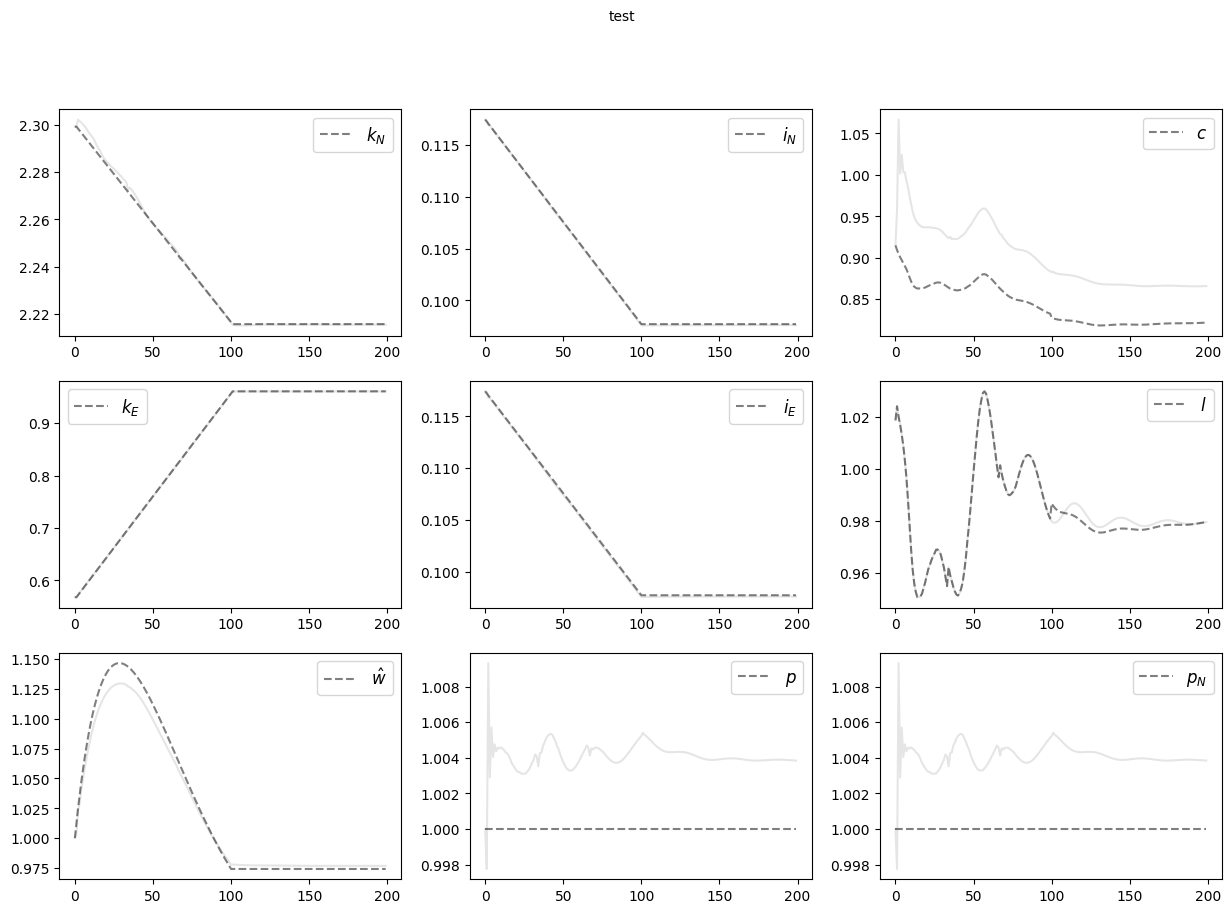

In [33]:
aggregate.fig